In [5]:
import glob
import os
import cv2
import glob
import importlib
import h5py
import json
import copy
import _pickle as pkl
import numpy as np
import pandas as pd
import seaborn as sns
import pylab as pl

In [6]:
import scipy.stats as spstats
import analyze2p.utils as hutils
import analyze2p.plotting as pplot

import analyze2p.receptive_fields.utils as rfutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.scatter as sct

In [37]:
rootdir = '/n/coxfs01/2p-data'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
# Receptive Field settings
traceid='traces001'
response_type='dff'
do_spherical_correction=False
is_neuropil = False

pplot.set_plot_params()
visual_areas, area_colors = pplot.set_threecolor_palette()

In [11]:
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
# meta['session_int'] = meta['session'].astype(int)

# dsets = meta[(meta.experiment==experiment) & (meta.visual_area==va)
#             & (meta['session_int']>=20190511)].copy()
# dsets

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets


In [12]:
basedir = os.path.join(aggregate_dir, 'receptive-fields', 'scatter')
print(basedir)
if not os.path.exists(basedir):
    os.makedirs(basedir)


/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/scatter


In [15]:
importlib.reload(sct)

<module 'analyze2p.scatter' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/scatter.py'>

In [20]:
# va='V1'
# dk = '20190617_JC097_fov1'

# df_ = sct.load_results(dk, va)
meta = sdata[sdata.experiment.isin(['rfs', 'rfs10'])].copy()

In [191]:
importlib.reload(sct)

<module 'analyze2p.scatter' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/scatter.py'>

In [221]:
missing=[]
d_list=[]
for (va, dk, exp), g in meta.groupby(['visual_area', 'datakey', 'experiment']):
    df_ = sct.load_results(dk, va, exp, verbose=False)
    if df_ is None:
        missing.append((va, dk, exp))
        continue
    df_['visual_area'] = va
    df_['datakey'] = dk
    df_['experiment'] = exp
    d_list.append(df_)

In [222]:
missing

[('V1', '20190511_JC083_fov1', 'rfs'),
 ('V1', '20190615_JC097_fov2', 'rfs10'),
 ('V1', '20191004_JC110_fov2', 'rfs10'),
 ('V1', '20191111_JC117_fov1', 'rfs10')]

In [194]:
df = pd.concat(d_list, axis=0)
df.shape

(5120, 7)

In [195]:
%matplotlib inline

In [196]:
bw_colors=dict((v, [0.7]*3) for v in visual_areas)
axis_colors={'az': [0.7]*3,
             'el': [0.5]*3}

In [197]:
df.groupby(['experiment', 'visual_area']).count()

cell  deg_scatter  dist_scatter  axis  datakey
experiment visual_area                                                
rfs        Li            140          140           140   140      140
           Lm            858          858           858   858      858
           V1           1538         1538          1538  1538     1538
rfs10      Li           1448         1448          1448  1448     1448
           Lm            222          222           222   222      222
           V1            914          914           914   914      914

In [223]:
r_=[]
for (va, dk), g in meta.groupby(['visual_area', 'datakey']):
    regr_ = sct.load_models(dk, va)
    regr_['visual_area'] = va
    regr_['datakey'] = dk
    r_.append(regr_)
REGR = pd.concat(r_, axis=0)


In [224]:
pass_regr = REGR[REGR['R2']>0.5].copy()
REGR.shape, pass_regr.shape

((108, 9), (71, 9))

In [272]:
r2_thr=0.5
pass_regr = pd.concat([r for (va, dk), r in REGR.groupby(['visual_area', 'datakey'])\
                       if (r[r.cond=='az']['R2'].values>=r2_thr) 
                       and (r[r.cond=='el']['R2'].values>=r2_thr)])

In [273]:
pass_regr[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts()

V1    13
Lm     9
Li     5
Name: visual_area, dtype: int64

In [274]:
passdf = pd.concat([g for (va, dk), g in df.groupby(['visual_area', 'datakey'])\
           if not pass_regr.query('@va==visual_area and @dk==datakey').empty])

In [275]:
f_=[]
for (va, dk), g in passdf.groupby(['visual_area', 'datakey']):
    if va in ['V1', 'Lm']:
        if 'rfs' in g['experiment'].values:
            f_.append(g[g.experiment=='rfs'])
        elif 'rfs10' in g['experiment'].values:
            f_.append(g[g.experiment=='rfs10'])
    elif va=='Li':
        if 'rfs10' in g['experiment'].values:
            f_.append(g[g.experiment=='rfs10'])
        elif 'rfs' in g['experiment'].values:
            f_.append(g[g.experiment=='rfs'])
finaldf0 = pd.concat(f_, axis=0)

In [276]:
counts = finaldf0[['visual_area', 'datakey', 'cell']].drop_duplicates()\
            .groupby(['visual_area', 'datakey']).count().reset_index()
u_dkeys = aggr.drop_repeats(counts)


In [277]:
finaldf = pd.concat([g for (va, dk), g in finaldf0.groupby(['visual_area', 'datakey'])\
                    if (va, dk) in u_dkeys])
print(finaldf0.shape, finaldf.shape)

(2316, 7) (1902, 7)


| visual_area   |   datakey |
|:--------------|----------:|
| Li            |         4 |
| Lm            |         5 |
| V1            |         8 |
[0 1 2]


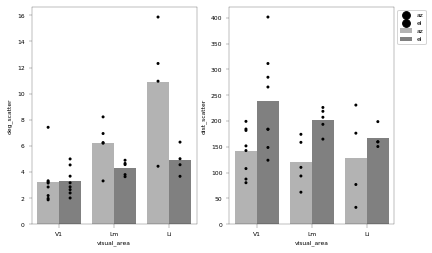

In [289]:
plotd = finaldf.groupby(['visual_area', 'datakey', 'axis']).mean().reset_index()
print(plotd[['visual_area', 'datakey']]\
      .drop_duplicates().groupby(['visual_area']).count()['datakey'].to_markdown())

fig, axn = pl.subplots(1,2, figsize=(6.5, 4))
ax=axn[0]
sns.barplot(x='visual_area', y='deg_scatter', data=plotd, ax=ax,
            order=visual_areas, hue='axis', palette=axis_colors, ci=None)
sns.stripplot(x='visual_area', y='deg_scatter', data=plotd, ax=ax,
             order=visual_areas, hue='axis', dodge=True,
             jitter=False, size=3,
             palette=dict((k, 'k') for k in ['az', 'el']))
ax.legend_.remove()
ax=axn[1]
sns.barplot(x='visual_area', y='dist_scatter', data=plotd, ax=ax,
              order=visual_areas, hue='axis', palette=axis_colors, ci=None)
sns.stripplot(x='visual_area', y='dist_scatter', data=plotd, ax=ax,
              order=visual_areas, hue='axis', dodge=True,
              jitter=False, size=3,
              palette=dict((k, 'k') for k in ['az', 'el']))
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
print(ax.get_xticks())

In [307]:
importlib.reload(pplot)

<module 'analyze2p.plotting' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py'>

|    |   t_stat |   p_val | visual_area   | metric       |
|---:|---------:|--------:|:--------------|:-------------|
|  0 |       14 |   0.641 | V1            | deg_scatter  |
|  1 |        1 |   0.125 | Lm            | deg_scatter  |
|  2 |        0 |   0.125 | Li            | deg_scatter  |
|  0 |        1 |   0.016 | V1            | dist_scatter |
|  1 |        0 |   0.062 | Lm            | dist_scatter |
|  2 |        3 |   0.625 | Li            | dist_scatter |


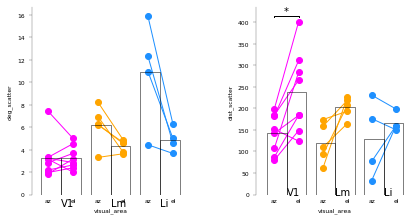

In [308]:
# Paired: spstats.wilcoxon()
offset=2
fig, axn = pl.subplots(1,2, figsize=(6.5, 4))
s_=[]
for ai, metric in enumerate(['deg_scatter', 'dist_scatter']):
    ax=axn[ai]
    ax, pstats = pplot.pairwise_compare_single_metric(plotd, 
                 curr_metric=metric, ax=ax,
                 c1='az', c2='el', compare_var='axis', 
                 ttest=False, return_stats=True, bar_ci=None)
    pstats['metric'] = metric
    pplot.annotate_sig_on_paired_plot(ax, plotd, pstats, metric, offset=10, h=2)
    s_.append(pstats)
statsdf = pd.concat(s_)
print(statsdf.to_markdown())

pl.subplots_adjust(left=0.1, right=0.9, wspace=0.5, bottom=0.2, top=0.85)

In [309]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

#perform two-way ANOVA
model = ols('deg_scatter ~ C(visual_area) + C(axis) + C(visual_area):C(axis)', \
            data=plotd).fit()
sm.stats.anova_lm(model, typ=2)


,sum_sq,df,F,PR(>F)
C(visual_area),115.266888,2.0,13.872533,0.000065
C(axis),32.364791,1.0,7.790296,0.009353
C(visual_area):C(axis),48.846344,2.0,5.878726,0.007385
Residual,116.326015,28.0,NaN,NaN


In [310]:
import pingouin as pg

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.3.12.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


<AxesSubplot:xlabel='visual_area', ylabel='deg_scatter'>

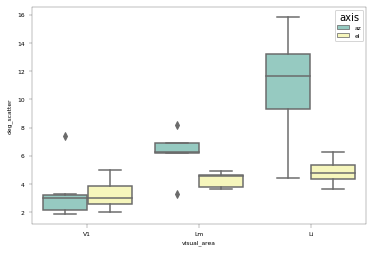

In [314]:
sns.boxplot(x='visual_area', y='deg_scatter', hue='axis', data=plotd, 
            order=visual_areas, palette='Set3')

In [341]:
plotd['subject'] = None
for vi, ((va, dk), g) in enumerate(plotd.groupby(['visual_area','datakey'])):
#     dkeys = list(plotd[plotd.visual_area==va]['datakey'].unique())
#     ix = dkeys.index(dk)
#     print(dk, ix)
    plotd.loc[g.index, 'subject'] = vi

In [352]:
aov_deg = pg.mixed_anova(data=plotd, dv='deg_scatter', between='visual_area',
                     within='axis', subject='subject', effsize='ng2')
aov_deg

,Source,SS,DF1,DF2,MS,F,p-unc,ng2,eps
0,visual_area,115.266888,2,14,57.633444,9.546567,0.002425,0.497713,NaN
1,axis,32.364791,1,14,32.364791,14.245597,0.002052,0.217665,1.0
2,Interaction,48.846344,2,14,24.423172,10.750036,0.001484,0.295730,NaN


In [353]:
aov_dist = pg.mixed_anova(data=plotd, dv='dist_scatter', between='visual_area',
                     within='axis', subject='subject', effsize='ng2')
aov_dist

,Source,SS,DF1,DF2,MS,F,p-unc,ng2,eps
0,visual_area,10950.011444,2,14,5475.005722,0.975942,0.401063,0.087898,NaN
1,axis,52305.426288,1,14,52305.426288,20.870631,0.000438,0.315223,1.0
2,Interaction,4572.946676,2,14,2286.473338,0.912336,0.424183,0.038689,NaN


In [361]:
# Having calculated the ANOVA, we can now run pairwise T-tests. By default, 
# Pingouin will calculate the within between interaction (in this case, year sex).
metric='deg_scatter'
pg.pairwise_ttests(data=plotd, dv=metric, between='visual_area', 
                   within='axis', subject='subject')

,Contrast,axis,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,hedges
0,axis,-,az,el,True,True,2.533878,16.000000,two-sided,0.022112,2.81,0.643577
1,visual_area,-,Li,Lm,False,True,1.722419,3.707817,two-sided,0.165711,1.107,1.130412
2,visual_area,-,Li,V1,False,True,3.035176,3.631722,two-sided,0.043755,4.372,2.208074
3,visual_area,-,Lm,V1,False,True,2.912020,9.781516,two-sided,0.015856,4.078,1.481073
4,axis * visual_area,az,Li,Lm,False,True,1.867557,3.684752,two-sided,0.141302,1.241,1.226848
5,axis * visual_area,az,Li,V1,False,True,3.093802,3.425396,two-sided,0.044868,4.676,2.342294
6,axis * visual_area,az,Lm,V1,False,True,2.870647,8.568098,two-sided,0.019393,3.879,1.526028
7,axis * visual_area,el,Li,Lm,False,True,0.949006,4.247038,two-sided,0.393432,0.662,0.610060
8,axis * visual_area,el,Li,V1,False,True,2.416741,5.871153,two-sided,0.052992,2.206,1.386413
9,axis * visual_area,el,Lm,V1,False,True,2.293351,10.874543,two-sided,0.042783,1.99,1.057472


In [362]:
# To get the between * within interaction, one can use the within_first argument:
pg.pairwise_ttests(data=plotd, dv=metric, between='visual_area', 
                   within='axis', subject='subject', within_first=False)


,Contrast,visual_area,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,hedges
0,visual_area,-,Li,Lm,False,True,1.722419,3.707817,two-sided,0.165711,1.107,1.130412
1,visual_area,-,Li,V1,False,True,3.035176,3.631722,two-sided,0.043755,4.372,2.208074
2,visual_area,-,Lm,V1,False,True,2.912020,9.781516,two-sided,0.015856,4.078,1.481073
3,axis,-,az,el,True,True,2.533878,16.000000,two-sided,0.022112,2.81,0.643577
4,visual_area * axis,Li,az,el,True,True,3.166409,3.000000,two-sided,0.050620,2.362,1.509118
5,visual_area * axis,Lm,az,el,True,True,2.845857,4.000000,two-sided,0.046591,2.333,1.271145
6,visual_area * axis,V1,az,el,True,True,-0.076373,7.000000,two-sided,0.941259,0.337,-0.022445


In [ ]:
# shapiro-test (should b p>0.05 if noramally distributed)
pg.

#  homogeneity of variance assumption of the between-subject factor (group) 
# can be checked using the Levene’s test
pg. # (homogeneuity of variances if p>0.05)


In [360]:
k = plotd['visual_area'].nunique()  # Number of groups
n = plotd.shape[0] / k  # Number of observations per group
print(k, n)
achieved_power = pg.power_anova(eta=aov.loc[0, 'ng2'], k=k, n=n, alpha=0.05)
print('Achieved power: %.4f' % achieved_power)

3 11.333333333333334
Achieved power: 0.3191


In [347]:
pg.pairwise_tukey(data=plotd, dv='deg_scatter', between='axis', within='visual_area')


TypeError: pairwise_tukey() got an unexpected keyword argument 'within'

In [338]:
plotd

,visual_area,datakey,axis,cell,deg_scatter,dist_scatter,subject
0,Li,20190527_JC092_fov3,az,79.693878,4.436419,32.481144,0
1,Li,20190527_JC092_fov3,el,79.693878,3.665362,159.458303,0
2,Li,20190617_JC099_fov1,az,40.550000,10.956967,76.810475,1
3,Li,20190617_JC099_fov1,el,40.550000,5.012103,159.682500,1
4,Li,20191017_JC113_fov1,az,164.903846,15.875299,230.820891,2
5,Li,20191017_JC113_fov1,el,164.903846,6.286676,198.714451,2
6,Li,20191106_JC120_fov1,az,102.785714,12.314810,176.319935,3
7,Li,20191106_JC120_fov1,el,102.785714,4.552553,150.431881,3
8,Lm,20190430_JC078_fov1,az,123.605263,8.219834,110.031237,0
9,Lm,20190430_JC078_fov1,el,123.605263,4.897407,164.813987,0


In [317]:
posthocs = pg.pairwise_ttests(dv='deg_scatter', within=['visual_area', 'axis'],
                             subject='datakey', data=plotd)
posthocs

ValueError: Repeated measures dataframe is not balanced. `Subjects` must have the same number of elements in all conditions, even when missing values are present.

In [324]:
pg.sphericity(data=plotd, dv='deg_scatter', subject='datakey', 
              within=['visual_area', 'axis'])[-1]

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/core/frame.py:8525: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


LinAlgError: Eigenvalues did not converge